In [1]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first
from monai.networks.nets import EfficientNet, EfficientNetBN

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import csv
import cv2
from PIL import Image
import math
Image.MAX_IMAGE_PIXELS = None

### 말뭉치 작성을 위한 label data들 가져오기

### label data로 char_map, index_map 만들어서 text_to_labels, labels_to_text 함수에 활용

In [2]:
file_path = '/Users/kim-wooseung/Desktop/bme_ai/project/train_labels.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

labels = [line.strip() for line in lines]

print(len(labels))

29453


In [3]:
file_path = '/Users/kim-wooseung/Desktop/bme_ai/project/valid_labels.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

valid_labels = [line.strip() for line in lines]

print(len(valid_labels))


7089


In [4]:
file_path = '/Users/kim-wooseung/Desktop/bme_ai/project/test_labels.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

test_labels = [line.strip() for line in lines]

print(len(test_labels))

687


## char_map, index_map 생성

In [5]:
chars = sorted(list(set(labels)))
test_chars = sorted(list(set(test_labels)))
valid_chars = sorted(list(set(valid_labels)))
all_chars = sorted(list(set(chars + test_chars + valid_chars)))

char_map = {char: i+1 for i, char in enumerate(all_chars)}
char_map['<unk>'] = 0
index_map = {i: char for char, i in char_map.items()}

print(len(char_map))
print(len(index_map))

5289
5289


In [6]:
class TextImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        label = text_to_labels(label, char_map)  
        label_length = [len(label)]
        return (image, torch.tensor(label), torch.tensor(label_length, dtype=torch.int32))

In [7]:
def text_to_labels(text, char_map):
    if isinstance(text, str):
        return [char_map[text]]  # Do not split the text into characters
    else:
        raise ValueError("The input to text_to_labels should be of type str.")

def labels_to_text(labels, index_map):
    if isinstance(labels, list) or isinstance(labels, torch.Tensor):
        # Convert each label to its corresponding character
        return "".join([index_map[label] for label in labels])  
    else:
        raise ValueError("The input to labels_to_text should be of type list or torch.Tensor.")

In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, labels, third_value = zip(*batch)

    # Padding sequences
    labels = pad_sequence(labels, batch_first=True)
    images = pad_sequence(images, batch_first=True)
    
    return images, labels

## RCNN Model

In [9]:
class CRNN(nn.Module):
    def __init__(self, num_chars):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # pool size and stride

            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2,2), stride=(2,1), padding=(0,1)),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2,2), stride=(2,1), padding=(0,1)),

            nn.Conv2d(512, 512, kernel_size=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d((2,2), stride=(2,1), padding=(0,1)),
        )


        self.rnn = nn.GRU(input_size=512, hidden_size=128, num_layers=2, bidirectional=True)

        self.fc = nn.Linear(256, num_chars)
    
    def forward(self, x):
        # Convolution layer
        conv = self.cnn(x)
        batch, channel, height, width = conv.size()
        conv = conv.view(batch, width, -1)  # reshape for RNN
        conv = conv.permute(1, 0, 2)  # to shape [seq_len, batch, input_size]

        # RNN layer
        output, _ = self.rnn(conv)

        # Fully connected layer
        output = self.fc(output)

        return output


In [10]:
from torchsummary import summary
num_chars = len(char_map) + 1
model= CRNN(num_chars)
summary(model, input_size=(1,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          36,992
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         590,080
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 9]               0
           Conv2d-13            [-1, 512, 4, 9]       1,180,160
      BatchNorm2d-14            [-1, 51

In [11]:
PATH = '/Users/kim-wooseung/Desktop/bme_ai/project/state_dict_model.pt'

model = CRNN(num_chars)
model.load_state_dict(torch.load(PATH))
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)


# Test

In [12]:
def evaluate_model(model, test_dataloader, criterion):
    model.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            batch_size = images.size(0)

            # Get model's predictions
            pred = model(images)

            # Define input_lengths and label_lengths
            input_lengths = torch.full(size=(batch_size,), fill_value=pred.size(0), dtype=torch.long)
            label_lengths = torch.full(size=(batch_size,), fill_value=labels.size(1), dtype=torch.long)

            # Compute CTC loss
            loss = criterion(pred.log_softmax(2), labels, input_lengths, label_lengths)
            total_loss += loss.item()

            _, max_probs = torch.max(pred, dim=2)

            # Compute accuracy
            pred_labels = max_probs.squeeze(0)
            pred_labels = pred_labels.transpose(0, 1)
            correct = (pred_labels == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(test_dataloader)
    avg_acc = total_correct / total_samples

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc*100:.2f}%')


In [13]:
def load_test_data(test_folder_path, test_labels_path, image_extensions=['JPG', 'jpg', 'jpeg', 'png']):
    # Load the image file paths
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(test_folder_path, f'*.{ext}')))

    # Sort the image paths
    image_paths.sort()

    # Load the images
    images = [torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE)[None, ...]).float()/255 for path in image_paths]

    # Load the labels
    with open(test_labels_path, 'r') as file:
        lines = file.readlines()

    labels = [line.strip() for line in lines]

    # Create a Dataset and DataLoader
    test_dataset = TextImageDataset(images=images, labels=labels)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)

    return test_dataloader

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [15]:
def visualize_mismatched_images(test_images, test_labels, model, index_map, num_images=16):
    model.eval()  # Set the model to evaluation mode
    plt.figure(figsize=(10, 10))
    images_1 = []
    labels_1 = []
    pred_1 = []

    with torch.no_grad():
        for i in range(len(test_images)):
            image = test_images[i].unsqueeze(0)  # Add an extra dimension for batch
            label = test_labels[i]
            pred = model(image)
            pred_label = torch.argmax(pred, dim=2).squeeze(0)
            num = pred_label[0].item()
            predicted_label = index_map[num]
            label = index_map[label.item()]
            images_1.append(test_images[i])
            labels_1.append(label)
            pred_1.append(predicted_label)

    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images_1[i].squeeze(), cmap='gray')
        plt.title(f'Predicted: {pred_1[i]}\nActual: {labels_1[i]}', fontsize=8)
        plt.axis('off')

    plt.show()


## test data set에서 batch=16으로 데이터 가져와서 plot한 결과

Test Loss: 3.8740, Test Accuracy: 73.80%


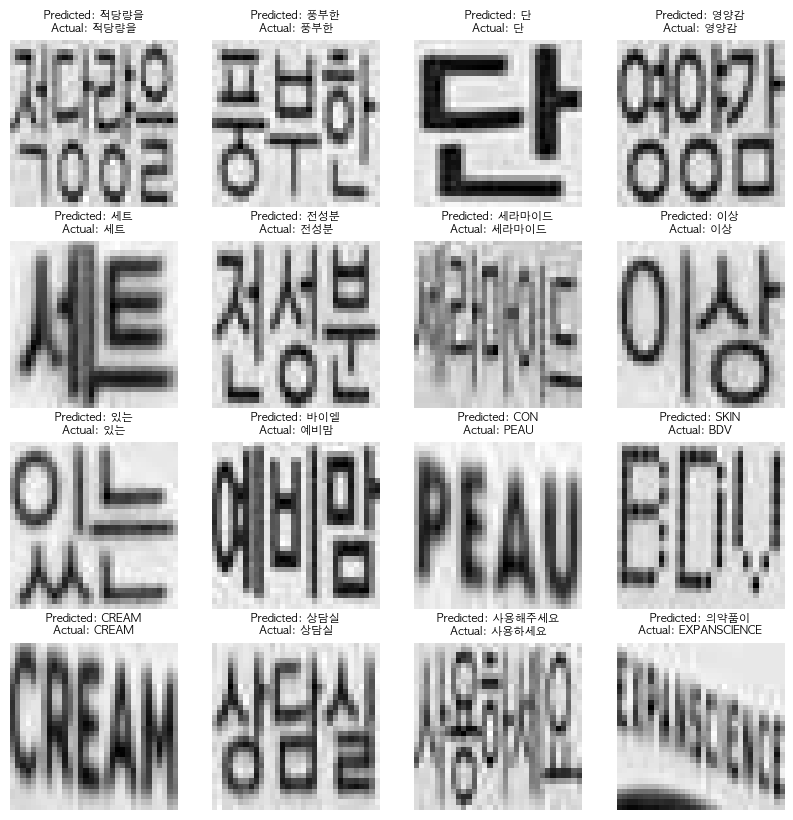

In [16]:
test_image_path = '/Users/kim-wooseung/Desktop/bme_ai/project/cropped_test_images'
test_label_path = '/Users/kim-wooseung/Desktop/bme_ai/project/test_labels.txt'
test_dataloader = load_test_data(test_image_path, test_label_path)

criterion = nn.CTCLoss(blank=0, zero_infinity=True)


evaluate_model(model, test_dataloader, criterion)


test_images, test_labels = next(iter(test_dataloader))
visualize_mismatched_images(test_images, test_labels, model, index_map, num_images=16)